In [1]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr

In [2]:
# Create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)

### Define constants to be used

In [17]:
dx = 5000. # meters
dy = 5000. # meters
dt = 1 # in days
H = [350.0, 750.0, 2900.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [.015, .0075]
delta_ek = 2. # meters
alpha_bc = 0.2 # nondimensional mixed boundary condition for OCEAN
gamma = 0.5*alpha_bc + 1 # nondimensional number for ease of calculation
mask = 0 # number of cells to mask at boundaries

In [4]:
tile_size = 100

#### RUN ONCE ONLY

#### ran on raijin with 32gb node. Takes about 70-80s per iteration

"""
indatadir = '/g/data1/v45/pm2987/Spunup'
outdatadir = '/g/data1/v45/jm0634/paige/Spunup_T'

for ncfile in ncfiles:
    outncfile = ncfile.replace(indatadir, outdatadir)
    outdir = os.path.dirname(outncfile)
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    if os.path.exists(outncfile):
        continue
        
    ds = xr.open_dataset(ncfile)\
           .isel(time=slice(None,-1)) # remove last time value since it repeated at the
                                      # start of each output file
    ds = ds.transpose('zi', 'z', 'yp', 'xp', 'time')
    
    encoding = { 'p'    : {'chunksizes': [1, 100, 100, 365]},
                 'q'    : {'chunksizes': [1, 100, 100, 365]},
                 'h'    : {'chunksizes': [1, 100, 100, 365]},
                 'taux' : {'chunksizes': [100, 100, 365]},
                 'tauy' : {'chunksizes': [100, 100, 365]},              
                 'e'    : {'chunksizes': [100, 100, 365]},
               }
    for v in encoding:
        encoding[v].update({'complevel': 0, 
                            'contiguous': False,
                            'dtype': np.dtype('float32'),
                            'source': ncfile,
                            'zlib': False})
    
    ds.to_netcdf(outncfile, engine='netcdf4', format='NETCDF4', encoding=encoding)
    del ds
"""

In [18]:
datadir = '/g/data1/v45/jm0634/paige/Spunup_T'

# Select the desired files
#ncfiles = sorted(glob(os.path.join(datadir, 'output*/ocpo.nc'))) # for all files
ncfiles = sorted(glob(os.path.join(datadir, 'output013/ocpo.nc'))) # for one year
#ncfiles = sorted(glob(os.path.join(datadir, 'output01*/ocpo.nc'))) # for seven years (1-7)

Construct a DataArray of all output files (takes a few seconds)

In [19]:
chunks = {'xp': tile_size, 'yp': tile_size, 
          'time':365, 'z':1, 'zi':1}

datasets = [xr.open_dataset(fn, 
                            chunks=chunks)
            for fn in ncfiles]

dsx = xr.concat(datasets, dim='time', coords='all')

### KE

$$
-\frac{H_1}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_1}^* 
\widehat{J(\nabla_H^2 p_1,p_1)}\right]
- \frac{H_2}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_2}^* 
\widehat{J(\nabla_H^2 p_2, p_2)}\right]
-\frac{H_3}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{J(\nabla_H^2 p_3, p_3)}\right]
$$

In [20]:
def calc_KE(dsx, tile_index, z=0):
    
    # Select variable
    p = dsx.p.isel(z=z)

    # Select specified tile, with 2-cell padding for taking of derivatives
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2),
               xp=slice(max(ix*tile_size-2,0), (ix+1)*tile_size+2))
    xp = p.xp.values # grab values of dask arrays
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    print('p shape with buffer of 2 on either side = ',p.shape)
    
    # Concatenate two columns/rows on ends for correct handling of boundaries in derivatives
    if ix==0:
        p = da.concatenate([(2./gamma)*p[:,slice(0,1),:] + ((gamma-2)/gamma)*p[:,slice(1,2),:], p], axis=1)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[:,slice(1,2),:] - (4/(gamma**2))*p[:,slice(2,3),:] + ((gamma-alpha_bc)/gamma)*p[:,slice(3,4),:], p], axis=1)
    if iy==0:
        p = da.concatenate([(2./gamma)*p[slice(0,1),:,:] + ((gamma-2)/gamma)*p[slice(1,2),:,:], p], axis=0)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(1,2),:,:] - (4/(gamma**2))*p[slice(2,3),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(3,4),:,:], p], axis=0)
    if ix==9:
        p = da.concatenate([(2./gamma)*p[:,slice(-1,None),:] + ((gamma-2)/gamma)*p[:,slice(-2,-1),:], p], axis=1)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[:,slice(-2,-1),:] - (4/(gamma**2))*p[:,slice(-3,-2),:] + ((gamma-alpha_bc)/gamma)*p[:,slice(-4,-3),:], p], axis=1)
    if iy==9:
        p = da.concatenate([(2./gamma)*p[slice(-1,None),:,:] + ((gamma-2)/gamma)*p[slice(-2,-1),:,:], p], axis=0)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(-2,-1),:,:] - (4/(gamma**2))*p[slice(-3,-2),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(-4,-3),:,:], p], axis=0)
    
    # Update size variables
    ny, nx, nt = p.shape
    print('after adding two cells for boundaries ',p.shape)
    p = p.rechunk(chunks={0: ny, 1: nx})
        
    def Jacobian(p):
        # Jacobian stencil
        p_cc = p
        p_ac = np.roll(p_cc,  2, axis=0)
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_ec = np.roll(p_cc, -2, axis=0)
    
        p_ca = np.roll(p_cc, -2, axis=1)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        p_ce = np.roll(p_cc,  2, axis=1)
    
        p_bb = np.roll(p_bc, -1, axis=1)
        p_bd = np.roll(p_bc,  1, axis=1)
        p_db = np.roll(p_dc, -1, axis=1)
        p_dd = np.roll(p_dc,  1, axis=1) 
        
        p_y = - p_cd + p_cb
        p_x = - p_bc + p_dc
        delp_y = - (p_ce + p_bd + p_dd - 4*p_cd) + (p_ca + p_bb + p_db - 4*p_cb)
        delp_x = - (p_bb + p_ac + p_bd - 4*p_bc) + (p_db + p_ec + p_dd - 4*p_dc)
    
        J = delp_x*p_y - delp_y*p_x
        
        return J

    # Evaluate the Jacobian function
    J = p.map_blocks(Jacobian)
    
    # Trim off added cells
    J = J[2:ny-2, 2:nx-2, :]
    p = p[2:ny-2, 2:nx-2, :]
    
    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    if ix == 0 and mask:
        J = J[:,slice(mask,None),:]
        p = p[:,slice(mask,None),:]
    if iy == 0 and mask:
        J = J[slice(mask,None),:,:]
        p = p[slice(mask,None),:,:]
    if ix == 9 and mask:
        J = J[:,slice(0,-mask),:]
        p = p[:,slice(0,-mask),:]
    if iy == 9 and mask:
        J = J[slice(0,-mask),:,:]
        p = p[slice(0,-mask),:,:]
        
    print('after masking 2 cells at boundary ',J.shape)

    # Multiplicative factor due to derivative
    J = (1./(4*(dx**4)))*J
    
    # Use smaller spatial chunks for fft
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    
    print('p shape after chunking/10 = ',p.shape)
        
    # Function that detrends, windows, and takes fft
    def fft_block(var):
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    Jhat = Jhat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    # Multiply by constants
    KE = -(H[z] / (f0**3 * Htot)) * ((phat.conj()*Jhat).real)
    
    print('final shape = ',KE.shape)

    # Sum over x- and y-axes
    KE = da.sum(KE, axis=(0,1))
    
    KE = KE.compute()
    
    # Wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    KE = xr.DataArray(KE, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return KE

In [21]:
calc_KE(dsx,(0,9))

p shape with buffer of 2 on either side =  (63, 102, 365)
after adding two cells for boundaries  (65, 104, 365)
after masking 2 cells at boundary  (61, 100, 365)
p shape after chunking/10 =  (61, 100, 365)
final shape =  (61, 100, 365)


<xarray.DataArray (freq: 183)>
array([ -1.534620e-06,   1.906413e-05,   1.800711e-05,  -6.702995e-05,
        -2.535142e-04,   1.284139e-06,  -3.675318e-05,  -1.517632e-04,
        -7.955957e-05,  -2.966024e-05,  -4.060298e-05,  -1.357023e-04,
        -7.913549e-05,  -1.886069e-05,   1.579723e-05,   4.935007e-05,
        -1.623771e-05,   1.378690e-06,  -1.388248e-05,  -6.437251e-06,
         3.490013e-06,   9.633961e-06,   4.911890e-06,   4.200741e-06,
        -1.051533e-05,  -3.397016e-06,   2.135813e-06,   2.237283e-06,
        -1.920734e-06,  -4.691832e-06,   3.365426e-06,   1.927823e-06,
        -5.624023e-07,  -5.108963e-06,  -2.917353e-07,   2.355851e-06,
        -5.284447e-07,   4.010040e-07,   9.095925e-07,   1.390787e-06,
        -1.894344e-07,  -8.748320e-07,  -7.624003e-08,  -1.243075e-07,
         6.121994e-07,  -4.920801e-07,  -6.118693e-07,  -9.749964e-07,
        -2.501183e-07,   6.269171e-07,  -1.332993e-07,  -3.437120e-07,
        -3.648076e-07,  -6.752334e-07,  -1.026

### PE


$$
-\frac{1}{f_0 H_{tot}} \frac{1}{g_1'}  \mathrm{Re}  \left[ \widehat{(p_2 - p_1)}^* \widehat{J( p_1,p_2)} \right]
- \frac{1}{f_0 H_{tot}} \frac{1}{g_2'}  \mathrm{Re}  \left[ \widehat{(p_3 - p_2)}^* \widehat{J( p_2,p_3)} \right]
$$


In [28]:
def calc_PE(dsx, tile_index, z=0):
    
    # Select variables
    p1 = dsx.p.isel(z=z)
    p2 = dsx.p.isel(z=z+1)
    
    # Work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    p2 = p2.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))

    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    
    # Concatenate one column/row on ends for correct handling of boundaries in derivatives
    if ix==0:
        p1 = da.concatenate([(2./gamma)*p1[:,slice(0,1),:] + ((gamma-2)/gamma)*p1[:,slice(1,2),:], p1], axis=1)
        p2 = da.concatenate([(2./gamma)*p2[:,slice(0,1),:] + ((gamma-2)/gamma)*p2[:,slice(1,2),:], p2], axis=1)
    if iy==0:
        p1 = da.concatenate([(2./gamma)*p1[slice(0,1),:,:] + ((gamma-2)/gamma)*p1[slice(1,2),:,:], p1], axis=0)
        p2 = da.concatenate([(2./gamma)*p2[slice(0,1),:,:] + ((gamma-2)/gamma)*p2[slice(1,2),:,:], p2], axis=0)
    if ix==9:
        p1 = da.concatenate([(2./gamma)*p1[:,slice(-1,None),:] + ((gamma-2)/gamma)*p1[:,slice(-2,-1),:], p1], axis=1)
        p2 = da.concatenate([(2./gamma)*p2[:,slice(-1,None),:] + ((gamma-2)/gamma)*p2[:,slice(-2,-1),:], p2], axis=1)
    if iy==9:
        p1 = da.concatenate([(2./gamma)*p1[slice(-1,None),:,:] + ((gamma-2)/gamma)*p1[slice(-2,-1),:,:], p1], axis=0)
        p2 = da.concatenate([(2./gamma)*p2[slice(-1,None),:,:] + ((gamma-2)/gamma)*p2[slice(-2,-1),:,:], p2], axis=0)
        
    ny, nx, nt = p1.shape
    p1 = p1.rechunk(chunks={0: ny, 1: nx})
    p2 = p2.rechunk(chunks={0: ny, 1: nx})

    # Take a single derivative
    def Derivative(p, axis):
        p_right = np.roll(p, 1, axis=axis)
        p_left = np.roll(p, -1, axis=axis)
        dp = p_left - p_right
        return dp
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    # Evaluate the derivative function
    p1x = p1.map_blocks(Derivative_x)
    p1y = p1.map_blocks(Derivative_y)
    p2x = p2.map_blocks(Derivative_x)
    p2y = p2.map_blocks(Derivative_y)
    
    J = p1x*p2y - p1y*p2x
    
    # Multiplicative factor due to derivative
    J = J/(4*(dx**2))
    
    pdiff = p2 - p1
    
    # Trim down to original tile size
    J = J[1:ny-1, 1:nx-1, :]
    pdiff = pdiff[1:ny-1, 1:nx-1, :]

    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    if ix == 0 and mask:
        J = J[:,slice(mask,None),:]
        pdiff = pdiff[:,slice(mask,None),:]
    if iy == 0 and mask:
        J = J[slice(mask,None),:,:]
        pdiff = pdiff[slice(mask,None),:,:]
    if ix == 9 and mask:
        J = J[:,slice(0,-mask),:] 
        pdiff = pdiff[:,slice(0,-mask),:]
    if iy == 9 and mask:
        J = J[slice(0,-mask),:,:]
        pdiff = pdiff[slice(0,-mask),:,:]
    
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Use smaller spatial chunks for fft
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 
                                  1: tile_size/10, 
                                  2: nt})
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    #pdiffhat = da.fft.rfft(pdiff, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    pdiffhat = pdiffhat.rechunk(chunks={0: tile_size, 
                                        1: tile_size, 
                                        2: 365})
    # Multiply by constants
    PE = -(1 / (f0 * Htot)*(1/g[0]))*(pdiffhat.conj()*Jhat).real

    # Sum over x- and y-axes
    PE = da.sum(PE, axis=(0,1))
    
    PE = PE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    PE = xr.DataArray(PE,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    return PE

## Buoyancy

$$
-\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{(p_2 - p_1)}^* \widehat{e_1} \right]
$$


In [29]:
def calc_buoyancy(dsx, tile_index):
    # Select variables
    p1 = dsx.p.isel(z=0)
    p2 = dsx.p.isel(z=1)
    e = dsx.e
    
    # Work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    e = e.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    e = e.data
    
    ny, nx, nt = p1.shape
    
    pdiff = p2 - p1
    
    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    if ix == 0 and mask:
        e = e[:,slice(mask,None),:]
        pdiff = pdiff[:,slice(mask,None),:]
    if iy == 0 and mask:
        e = e[slice(mask,None),:,:]
        pdiff = pdiff[slice(mask,None),:,:]
    if ix == 9 and mask:
        e = e[:,slice(0,-mask),:]
        pdiff = pdiff[:,slice(0,-mask),:]
    if iy == 9 and mask:
        e = e[slice(0,-mask),:,:]
        pdiff = pdiff[slice(0,-mask),:,:]
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    e = e.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    ehat = e.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    e = e.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    pdiff = pdiff.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    buoyancy = -(1 / Htot)*(pdiffhat.conj()*ehat).real

    # Sum over x- and y-axes
    buoyancy = da.sum(buoyancy, axis=(0,1))
    
    buoyancy = buoyancy.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    buoyancy = xr.DataArray(buoyancy,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return buoyancy

## Windstress

$$
-\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{p_1}^* \widehat{w_{ek}} \right]
$$

In [30]:
def calc_windstress(dsx, tile_index):
    # Select variables
    p = dsx.p.isel(z=0) # dimensions: (y,x,time) = (lat,lon,time)
    taux = dsx.taux
    tauy = dsx.tauy
    
    # Work with DaskArrays
    #   - Cut 100 piece chunks, with padding on edges for derivatives
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size,0), (iy+1)*tile_size),
                 xp=slice(max(ix*tile_size,0), (ix+1)*tile_size))
    taux = taux.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    tauy = tauy.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    # Put into numpy arrays (to access the data)
    p = p.data
    taux = taux.data 
    tauy = tauy.data
    
    # Concatenate rows/columns for boundary handling in derivative
    if ix==0:
        taux = da.concatenate([taux[:,slice(0,1),:], taux], axis=1)
        tauy = da.concatenate([tauy[:,slice(0,1),:], tauy], axis=1)
    if iy==0:
        taux = da.concatenate([taux[slice(0,1),:,:], taux], axis=0)
        tauy = da.concatenate([tauy[slice(0,1),:,:], tauy], axis=0)
    if ix==9:
        taux = da.concatenate([taux, taux[:,slice(-1,None),:]], axis=1)
        tauy = da.concatenate([tauy, tauy[:,slice(-1,None),:]], axis=1)
    if iy==9:
        taux = da.concatenate([taux, taux[slice(-1,None),:,:]], axis=0)
        tauy = da.concatenate([tauy, tauy[slice(-1,None),:,:]], axis=0)
        
    ny, nx, nt = taux.shape
    taux = taux.rechunk(chunks={0: ny, 1: nx})
    tauy = tauy.rechunk(chunks={0: ny, 1: nx})

    def Derivative(tau, axis):
        tau_right = np.roll(tau, 1, axis=axis)
        tau_left = np.roll(tau, -1, axis=axis)
        dtau = tau_left - tau_right
        return dtau
        
    Derivative_x = lambda tau: Derivative(tau, 1)
    Derivative_y = lambda tau: Derivative(tau, 0)
    
    # Run the derivative function
    tauy_x = tauy.map_blocks(Derivative_x)
    taux_y = taux.map_blocks(Derivative_y)

    # Define Ekman velocity
    wek = (1./f0) * (tauy_x - taux_y)
    
    # Trim matrix down to desired size after derivative
    wek = wek[1:ny-1, 1:nx-1, :]
    
    # Construct ds: matrix of constants to divide by in taking of derivative
    ds = da.ones(wek.shape, chunks=wek.chunks)*2*dx
    if ix==0:
        ds = da.concatenate( [ ds[:,slice(0,1),:]/2, ds[:,1:,:] ], axis = 1)
    if iy==0:
        ds = da.concatenate( [ ds[slice(0,1),:,:]/2, ds[1:,:,:] ], axis = 0)
    if ix==9:
        ds = da.concatenate( [ ds[:,slice(-1,None),:]/2, ds[:,:-1,:] ], axis = 1)
    if iy==9:
        ds = da.concatenate( [ ds[slice(-1, None),:,:]/2, ds[:-1,:,:] ], axis = 0)
        
    # Divide needed for derivatives
    wek = wek / ds
    
    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    if ix == 0 and mask:
        wek = wek[:,slice(mask,None),:]
        p = p[:,slice(mask,None),:]
    if iy == 0 and mask:
        wek = wek[slice(mask,None),:,:]
        p = p[slice(mask,None),:,:]
    if ix == 9 and mask:
        wek = wek[:,slice(0,-mask),:]
        p = p[:,slice(0,-mask),:]
    if iy == 9 and mask:
        wek = wek[slice(0,-mask),:,:]
        p = p[slice(0,-mask),:,:]
    
    # fft function
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat

    # Rechunk arrays into even smaller chunks for fft calculation
    wek = wek.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    
    # Execute fft function above
    wekhat = wek.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    wek = wek.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    p = p.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply together
    windstress = -(1 / Htot)*(phat.conj()*wekhat).real

    # Sum over x- and y-axes
    windstress = da.sum(windstress, axis=(0,1))
    
    windstress = windstress.compute()
    
    # Wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    windstress = xr.DataArray(windstress,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return windstress

In [8]:
%%time
windstress = calc_windstress(dsx,(1,0))

CPU times: user 2.19 s, sys: 66 ms, total: 2.26 s
Wall time: 6.36 s


### Bottom Drag

$$
\frac{\delta _{ek}}{2 f_0 H_{tot}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{\nabla_H^2 p_3}\right]
$$

In [31]:
def calc_bottomDrag(dsx, tile_index):
    
    # Select variables
    p = dsx.p.isel(z=2)
        
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
               xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    
    # Concatenate one column/row on ends for correct handling of boundaries in derivatives
    if ix==0:
        p = da.concatenate([(2/gamma)*p[:,slice(0,1),:] + ((alpha_bc-gamma)/gamma)*p[:,slice(1,2),:], p], axis=1)
    if iy==0:
        p = da.concatenate([(2/gamma)*p[slice(0,1),:,:] + ((alpha_bc-gamma)/gamma)*p[slice(1,2),:,:], p], axis=0)
    if ix==9:
        p = da.concatenate([p, (2/gamma)*p[:,slice(-1,None),:] + ((alpha_bc-gamma)/gamma)*p[:,slice(-2,-1),:]], axis=1)
    if iy==9:
        p = da.concatenate([p, (2/gamma)*p[slice(-1,None),:,:] + ((alpha_bc-gamma)/gamma)*p[slice(-2,-1),:,:]], axis=0)
        
    ny, nx, nt = p.shape
    p = p.rechunk(chunks={0: ny, 1: nx})
        
    # Function for calculating del**2 (Laplacian)
    def del2(p):
        # stencil
        p_cc = p
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        
        del2p = p_dc + p_cd + p_bc + p_cb - 4*p_cc

        return del2p

    # Run the del2 function
    del2p = p.map_blocks(del2)

    # Divide for derivative
    del2p = (1./(dx**2))*del2p
    
    del2p = del2p[1:ny-1, 1:nx-1, :]
    p = p[1:ny-1, 1:nx-1, :]
    
    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    if ix == 0 and mask:
        del2p = del2p[:,slice(mask,None),:]
        p = p[:,slice(mask,None),:]
    if iy == 0 and mask:
        del2p = del2p[slice(mask,None),:,:]
        p = p[slice(mask,None),:,:]
    if ix == 9 and mask:
        del2p = del2p[:,slice(0,-mask),:] 
        p = p[:,slice(0,-mask),:]
    if iy == 9 and mask:
        del2p = del2p[slice(0,-mask),:,:]
        p = p[slice(0,-mask),:,:]
    
    # fft function
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Rechunk for faster FFT
    del2p = del2p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    
    # Execute fft function above
    del2phat = del2p.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    del2phat = del2phat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    # Multiply all together
    bottomDrag = (delta_ek / (2. * f0 * Htot)) *(phat.conj()*del2phat).real

    # Sum over x- and y-axes
    bottomDrag = da.sum(bottomDrag, axis=(0,1))
    
    bottomDrag = bottomDrag.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    bottomDrag = xr.DataArray(bottomDrag, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return bottomDrag

In [14]:
%%time
calc_bottomDrag(dsx,(0,9))

CPU times: user 483 ms, sys: 31 ms, total: 514 ms
Wall time: 1.08 s


<xarray.DataArray (freq: 183)>
array([ -2.732195e-08,  -8.235846e-07,  -8.039153e-07,  -4.962847e-07,
        -9.042447e-07,  -4.527186e-08,  -1.315214e-07,  -7.152000e-07,
        -2.406202e-07,  -1.868686e-07,  -1.126985e-07,  -9.450350e-08,
        -6.587824e-08,  -8.966533e-08,  -6.045094e-08,  -8.747214e-08,
        -5.096548e-08,  -2.053167e-08,  -2.658402e-08,  -1.507315e-08,
        -1.102363e-08,  -1.572974e-08,  -1.830069e-08,  -6.866107e-09,
        -9.707893e-09,  -8.309363e-09,  -9.376025e-09,  -5.628341e-09,
        -6.943819e-09,  -1.150071e-08,  -6.817831e-09,  -6.720187e-09,
        -3.261049e-09,  -6.459444e-09,  -4.358252e-09,  -5.269148e-09,
        -5.504331e-09,  -3.832759e-09,  -2.429644e-09,  -2.068393e-09,
        -3.398658e-09,  -3.285982e-09,  -1.785943e-09,  -1.825487e-09,
        -2.058920e-09,  -1.937363e-09,  -1.766673e-09,  -1.445985e-09,
        -9.612321e-10,  -9.493873e-10,  -1.457080e-09,  -1.662256e-09,
        -1.095083e-09,  -7.319936e-10,  -8.037

In [40]:
%%time
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range((961+tile_size+1)//(tile_size)) 
xi = range((961+tile_size+1)//(tile_size))

tile_indexes = list(product(*[yi, xi]))

KE1_sum = 0
KE2_sum = 0
KE3_sum = 0
buoyancy_sum = 0
PE1_sum = 0
PE2_sum = 0
windstress_sum = 0
bottomDrag_sum = 0
for tile_index in tile_indexes[:]:
    KE1 = calc_KE(dsx, tile_index, 0)
    KE2 = calc_KE(dsx, tile_index, 1)
    KE3 = calc_KE(dsx, tile_index, 2)
    KE1_sum += KE1
    KE2_sum += KE2
    KE3_sum += KE3
    
#     PE1 = calc_PE(dsx, tile_index, 0)
#     PE2 = calc_PE(dsx, tile_index, 1)
#     PE1_sum += PE1
#     PE2_sum += PE2

#     windstress = calc_windstress(dsx,tile_index)
#     windstress_sum += windstress
    
#     buoyancy = calc_buoyancy(dsx, tile_index)
#     buoyancy_sum += buoyancy
    
#     bottomDrag = calc_bottomDrag(dsx,tile_index)
#     bottomDrag_sum += bottomDrag
    

p shape with buffer of 2 on either side =  (102, 102, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (102, 102, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (102, 102, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 102, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (63, 104, 365)
after adding two cells for boundaries  (65, 104, 365)
after masking 2 cells at boundary  (61, 100, 365)
p shape after chunking/10 =  (61, 100, 365)
final shape =  (61, 100, 365)
p shape with buffer of 2 on either side =  (63, 104, 365)
after adding two cells for boundaries  (65, 104, 365)
after masking 2 cells at boundary  (61, 100, 365)
p shape after chunking/10 =  (61, 100, 365)
final shape =  (61, 100, 365)
p shape with buffer of 2 on either side =  (63

p shape with buffer of 2 on either side =  (102, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (102, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (102, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either side =  (104, 104, 365)
after adding two cells for boundaries  (104, 104, 365)
after masking 2 cells at boundary  (100, 100, 365)
p shape after chunking/10 =  (100, 100, 365)
final shape =  (100, 100, 365)
p shape with buffer of 2 on either s

p shape with buffer of 2 on either side =  (104, 63, 365)
after adding two cells for boundaries  (104, 65, 365)
after masking 2 cells at boundary  (100, 61, 365)
p shape after chunking/10 =  (100, 61, 365)
final shape =  (100, 61, 365)
p shape with buffer of 2 on either side =  (104, 63, 365)
after adding two cells for boundaries  (104, 65, 365)
after masking 2 cells at boundary  (100, 61, 365)
p shape after chunking/10 =  (100, 61, 365)
final shape =  (100, 61, 365)
p shape with buffer of 2 on either side =  (104, 63, 365)
after adding two cells for boundaries  (104, 65, 365)
after masking 2 cells at boundary  (100, 61, 365)
p shape after chunking/10 =  (100, 61, 365)
final shape =  (100, 61, 365)
p shape with buffer of 2 on either side =  (104, 63, 365)
after adding two cells for boundaries  (104, 65, 365)
after masking 2 cells at boundary  (100, 61, 365)
p shape after chunking/10 =  (100, 61, 365)
final shape =  (100, 61, 365)
p shape with buffer of 2 on either side =  (104, 63, 365

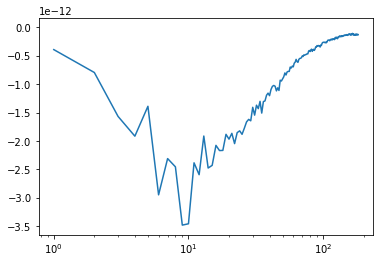

In [37]:
# Plot buoyancy (with detrend and window before FFT)
np.save("Tbuoyancy_output013_clean_correctsign",buoyancy_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(buoyancy_sum*ktiso)

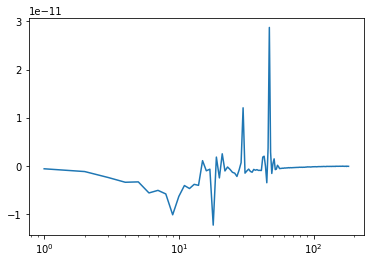

In [35]:
# Plot windstress (with detrend and window before FFT)
np.save("Twindstress_output013_clean_correctsign",windstress_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(windstress_sum*ktiso)

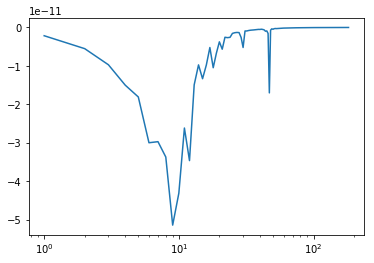

In [39]:
# Plot bottom drag (with detrend and window before FFT)
np.save("TbottomDrag_output013_clean_correctsign",bottomDrag_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(bottomDrag_sum*ktiso)

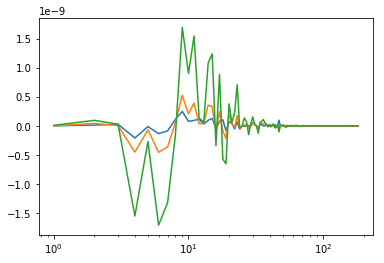

In [42]:
# Plot KE (with detrend and window before FFT)
np.save("TKE1_output013_clean_correctsign",KE1_sum)
np.save("TKE2_output013_clean_correctsign",KE2_sum)
np.save("TKE3_output013_clean_correctsign",KE3_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(KE1_sum*ktiso)
plt.semilogx(KE2_sum*ktiso)
plt.semilogx(KE3_sum*ktiso)

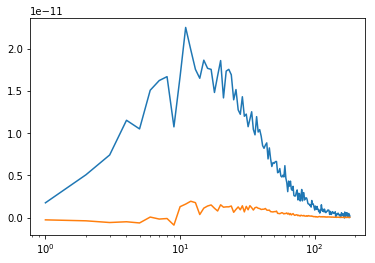

In [33]:
# Plot PE (with detrend and window before FFT)
np.save("TPE1_output013_clean_correctsign",PE1_sum)
np.save("TPE2_output013_clean_correctsign",PE2_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(PE1_sum*ktiso)
plt.semilogx(PE2_sum*ktiso)